In [0]:
# Recurrent Neural Network


In [0]:

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
import datetime
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Importing the Keras libraries and packages
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential  # linear stack of layers
from keras.layers import Dense
from keras.layers import LSTM        # Long Short-Term Memory layer
from keras.layers import Dropout     # simple way to prevent overfitting

In [0]:
# Configuration

SHARE = 'AAPL'
SERVICE = 'yahoo'

PREDICTORS = ['High', 'Low', 'Open']   # column names with prices
TARGET = 'Open'

TIMESTEP = 6  # the number of previous days used for prediction

START_DATE = datetime.datetime(2010, 1, 1)
END_DATE = datetime.datetime(2019, 9, 30)

START_DATE_TO_PREDICT = datetime.datetime(2019, 10, 1)
END_DATE_TO_PREDICT = datetime.datetime(2019, 10, 31)

# Parameters for Grid Search
BATCH_SIZES = [32, 64]
N_EPOCHS = [10, 20]
OPTIMIZERS = ['adam', 'rmsprop']


In [0]:
# Download stock price data
df_train = web.DataReader(SHARE, SERVICE, START_DATE, END_DATE)
df_test = web.DataReader(SHARE, SERVICE, START_DATE_TO_PREDICT, END_DATE_TO_PREDICT)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-10-14,238.130005,234.669998,234.899994,235.869995,24106900,235.869995
2019-10-15,237.649994,234.880005,236.389999,235.320007,21840000,235.320007
2019-10-16,235.240005,233.199997,233.369995,234.369995,18475800,234.369995
2019-10-17,236.149994,233.520004,235.089996,235.279999,16896300,235.279999
2019-10-18,237.580002,234.289993,234.589996,236.410004,24358400,236.410004


In [0]:
# Data preprocessing

# Removing irrelevant columns
df_train = df_train[PREDICTORS]
df_test = df_test[PREDICTORS]

In [0]:
# Creating numpy 2-dim array for the training set
# size N x K, where N - number of observations
# K - number of predictors

training_set = df_train.values


In [0]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [0]:
# Creating a data structure with timesteps and 1 output
# X_train - 3-dim array size of N x M x K, where 
# N - number of observations
# M - number of previous days (TIMESTEP)
# K - number of predictors/indicators
 
X_train = []
y_train = []
target_col_index = df_train.columns.get_loc(TARGET)
for i in range(TIMESTEP, len(training_set)):
    X_train.append(training_set_scaled[i-TIMESTEP:i, :])       # X_train - list of Numpy arrays
    y_train.append(training_set_scaled[i, target_col_index])
X_train, y_train = np.array(X_train), np.array(y_train)        # convert list to Numpy array


In [0]:
def build_regressor(optimizer):
    regressor = Sequential() # Initialising the RNN
    regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    regressor.add(Dropout(0.2)) # Dropout regularisation
    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units = 1)) # output layer is classic fully connected neural network layer : each input node is connected to each output node
    
    # use MSE instead RMSE (Root Mean Squared Error) because we are more interested in the directions taken by our predictions, rather than the closeness of their values to the real stock price
    regressor.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mean_squared_error'])  #https://github.com/keras-team/keras/issues/7947
   
    return regressor

In [0]:
regressor = KerasRegressor(build_fn = build_regressor)
parameters = {'batch_size': BATCH_SIZES,
              'epochs': N_EPOCHS,
              'optimizer': OPTIMIZERS}


grid_search = GridSearchCV(estimator = regressor,
                           param_grid = parameters,
                           scoring = 'neg_mean_squared_error',
                           cv = 10)
grid_search = grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_
print(best_parameters)
print(best_accuracy)

Epoch 1/10
2201/2201 [==============================] - 8s 4ms/step - loss: 0.0348 - mean_squared_error: 0.0348
Epoch 2/10
2201/2201 [==============================] - 2s 867us/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 3/10
2201/2201 [==============================] - 2s 863us/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 4/10
2201/2201 [==============================] - 2s 868us/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 5/10
2201/2201 [==============================] - 2s 883us/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 6/10
2201/2201 [==============================] - 2s 864us/step - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 7/10
2201/2201 [==============================] - 2s 853us/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 8/10
2201/2201 [==============================] - 2s 861us/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 9/10
2201/2201 [==============================] - 2s 902us/step - loss: 0.0023 - mea

In [0]:
# Extracting real prices
real_stock_price = df_test[TARGET].values

# Preparing input data for making predictions
df_total = df_train.append(df_test)
inputs = df_total[len(df_total) - len(df_test) - TIMESTEP:][PREDICTORS]

inputs = sc.transform(inputs)


X_test = []
for i in range(TIMESTEP, TIMESTEP+len(df_test)):
    X_test.append(inputs[i-TIMESTEP:i, :])
X_test = np.array(X_test)

In [0]:
# Making the predictions

predicted_stock_price = grid_search.predict(X_test)

# to perform inverse scaler transformation, at first we need to transform 
# 1-dimensional array with predicted prices to 2-dim array of size N x K, 
# where N = number of observations/predictions. 
# K = number of predictors

temp_matrix = np.zeros((len(predicted_stock_price), len(PREDICTORS)))
temp_matrix[:,target_col_index:target_col_index+1] = predicted_stock_price  # temp_matrix[:,[target_col_index]] = predicted_stock_price    

predicted_stock_price = sc.inverse_transform(temp_matrix)[:,target_col_index]

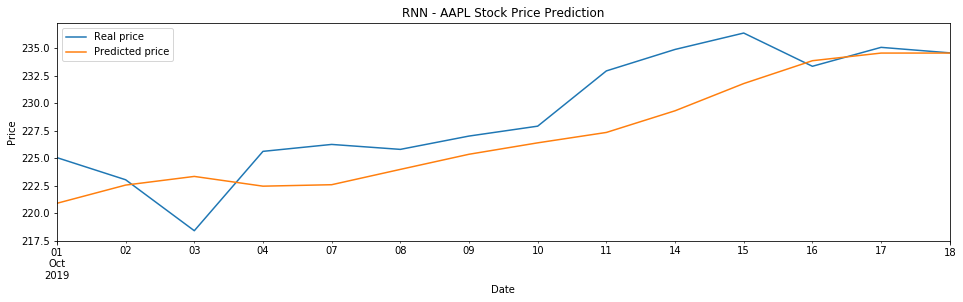

In [211]:
#df_predicted = pd.DataFrame(index=df_test.index)
#df_predicted[TARGET] = predicted_stock_price

df_test['Predicted price'] = predicted_stock_price
df_test[TARGET].plot(figsize=(16,4),legend=True)
df_test['Predicted price'].plot(figsize=(16,4),legend=True)
plt.legend(['Real price', 'Predicted price'])
plt.title('RNN - ' + SHARE + ' Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [212]:
# Evaluating model
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print("The RMSE is {:.3f}.".format(rmse))

The RMSE is 3.353.
